In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sys
from transformers import AutoTokenizer
import pandas as pd #🐼
import seaborn as sns
%matplotlib inline

In [2]:
sys.path.insert(0, '../code')

In [3]:
import data_analysis_functions as da
import data_process

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/kyonkyon/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(300,)))
model.add(tf.keras.layers.Embedding(30523, 256))
model.add(tf.keras.layers.Conv1D(filters = 150, kernel_size=2))
model.add(tf.keras.layers.MaxPooling1D(pool_size=11))
model.add(tf.keras.layers.Conv1D(filters = 11, kernel_size=1))
model.add(tf.keras.layers.Conv1D(filters = 11, kernel_size=1))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(242, return_sequences=True), input_shape=(5, 10)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(242)))
model.add(tf.keras.layers.Dense(182, activation='tanh'))
model.add(tf.keras.layers.Dense(1, activation='tanh'))
model.compile(loss='mse',
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 256)          7813888   
                                                                 
 conv1d (Conv1D)             (None, 299, 150)          76950     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 150)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 11)            1661      
                                                                 
 conv1d_2 (Conv1D)           (None, 27, 11)            132       
                                                                 
 bidirectional (Bidirectiona  (None, 27, 484)          491744    
 l)                                                     

In [6]:
train_df = da.importData('../code/data/training_set.csv')
test_df = da.importData('../code/data/test_set.csv')
train_df = data_process.data_vectorization(train_df)
test_df = data_process.data_vectorization(test_df)

In [7]:
def filter_long_descriptions(tokenizer, descriptions, max_len):
    indices = []
    lengths = tokenizer(descriptions, padding=False,
                     truncation=False, return_length=True)['length']
    for i in range(len(descriptions)):
        if lengths[i] <= max_len - 2:
            indices.append(i)
    return indices

In [8]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/hateBERT")


In [9]:
def short_description(df):
    # print(df.cleaned_comment.tolist())
    short_descriptions = filter_long_descriptions(tokenizer, df.cleaned_comment.tolist(), 300)
    # print('short descriptions')
    # print(short_descriptions)
    data = np.array(df['encoded_comment'])[short_descriptions]
    # print(data)
    target = df['score']
    return data, target

In [10]:
train_data, train_target = short_description(train_df)
test_data, test_target = short_description(test_df)

In [11]:
for i in range(len(train_data)):
    train_data[i] = np.array(train_data[i]).astype(np.float32)
    train_data[i] = train_data[i].flatten()

In [12]:
model.fit(np.stack(train_data, 0), train_target, epochs = 7)
# score = self.model.predict(np.stack(test_data, 0)).flatten()
result = model.evaluate(np.stack(test_data, 0), test_target)

Epoch 1/7
144/144 [==============================] - 94s 538ms/step - loss: 0.0755
Epoch 2/7
144/144 [==============================] - 73s 506ms/step - loss: 0.0248
Epoch 3/7
144/144 [==============================] - 46s 317ms/step - loss: 0.0112
Epoch 4/7
144/144 [==============================] - 43s 299ms/step - loss: 0.0077
Epoch 5/7
144/144 [==============================] - 43s 297ms/step - loss: 0.0055
Epoch 6/7
144/144 [==============================] - 43s 301ms/step - loss: 0.0038
Epoch 7/7
35/35 [==============================] - 4s 75ms/step - loss: 0.0369


In [13]:
result

0.03693462535738945

In [14]:
score = model.predict(np.stack(test_data, 0)).flatten()

In [15]:
data = {'comment':test_df['comment'], 'score':test_target, 'model score':score}
result_df = pd.DataFrame(data=data)

In [16]:
result_df

,comment,score,model score
0,I’d start by not clicking on things that make ...,0.312,0.190875
1,If you count killing civilians as a success (w...,0.104,0.132111
2,"Sure, if it's private, why not?",-0.574,-0.355241
3,"Dude, most of these people support VERY LATE a...",0.438,0.372574
4,So you'll be OK if Trump gets elected and bypa...,0.062,-0.078070
5,"Dont worry, it did a pretty good job of censor...",-0.354,-0.054786
6,"Humans do inherit traits, but they do NOT inhe...",-0.312,-0.148651
7,Been in politics 50 years Joe. So it’s just no...,0.213,-0.129721
8,That's a perfectly valid criticism to make. B...,-0.085,0.008690
9,What should they do? Welcome Hamas with open a...,-0.042,0.094578


In [17]:
confusion_matrix = [
    [0, 0, 0], 
    [0, 0, 0], 
    [0, 0, 0], 
]

In [40]:
count1 = 0
count2 = 0
for index, row in result_df.iterrows():
    #non offensive
    if row['score'] <= -0.4:
        if row['model score'] <= -0.4:
            confusion_matrix[0][0] = confusion_matrix[0][0] + 1
        elif row['model score'] >= 0.4:
            confusion_matrix[0][2] = confusion_matrix[0][2] + 1
        else:
            confusion_matrix[0][1] = confusion_matrix[0][1] + 1
    #offensive 
    elif row['score'] >= 0.4:
        if row['model score'] <= -0.4:
            confusion_matrix[2][0] = confusion_matrix[2][0] + 1
        elif row['model score'] >= 0.4:
            confusion_matrix[2][2] = confusion_matrix[2][2] + 1
        else:
            confusion_matrix[2][1] = confusion_matrix[2][1] + 1     
    #neutral
    else:
        if row['model score'] <= -0.4:
            confusion_matrix[1][0] = confusion_matrix[1][0] + 1
        elif row['model score'] >= 0.4:
            confusion_matrix[1][2] = confusion_matrix[1][2] + 1
        else:
            confusion_matrix[1][1] = confusion_matrix[1][1] + 1

    dif = abs(row['score']) - abs(row['model score'])
    if abs(dif) < 0.2:
        count1 = count1 + 1 
    if abs(dif) < 0.1:
        count2 = count2 + 1
accuracy1 = count1 / len(result_df)
accuracy2 = count2 / len(result_df)

In [41]:
confusion_matrix

[[98, 269, 0], [55, 4622, 60], [0, 173, 304]]

In [42]:
labels = ['Non Offensive', 'Neutral', 'Offensive']

In [43]:
cf_df = pd.DataFrame(data=confusion_matrix, columns=labels, index=labels)

<AxesSubplot:>

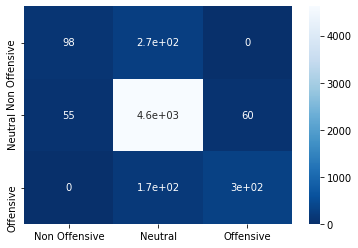

In [44]:
sns.heatmap(cf_df, annot=True, cmap="Blues_r")

In [33]:
print('MSE : ', result)

MSE :  0.03693462535738945


In [34]:
print('Accuracy (>0.2): ', accuracy1)
print('Accuracy (>0.1): ', accuracy2)

Accuracy (>0.2):  0.782258064516129
Accuracy (>0.1):  0.496415770609319
